## Neural Collaborative Filtering

### Import necessary modules

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Enable multiple output cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/Shareddrives/CMPE_257_Project/serendipity-sac2018

/content/gdrive/Shareddrives/CMPE_257_Project/serendipity-sac2018


In [ ]:
# Load training dataset which contains the ratings for movies by different users
training_full = pd.read_csv("/content/training.csv")
training_full.head()

,userId,movieId,rating,timestamp
0,142882,91658,2.5,1515209647000
1,142882,4344,1.0,1515209646000
2,142882,45720,2.0,1515209643000
3,142882,4734,2.0,1515209641000
4,142882,91542,2.0,1515209637000


In [ ]:
# Drop unnecessary columns
cols_to_drop = ['timestamp']
training_full.drop(cols_to_drop, axis = 1, inplace = True)
training_full.head()

,userId,movieId,rating
0,142882,91658,2.5
1,142882,4344,1.0
2,142882,45720,2.0
3,142882,4734,2.0
4,142882,91542,2.0


In [ ]:
user_ids = training_full["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = training_full["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
training_full["user"] = training_full["userId"].map(user2user_encoded)
training_full["movie"] = training_full["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
training_full["rating"] = training_full["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(training_full["rating"])
max_rating = max(training_full["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 104661, Number of Movies: 49151, Min rating: 0.5, Max rating: 5.0


In [ ]:
training_full = training_full.sample(frac=1, random_state=42)
x = training_full[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = training_full["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 80% of the data and validating on 20%.
train_indices = int(0.8 * training_full.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=2,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/2
124974/124974 [==============================] - 881s 7ms/step - loss: 0.7182 - val_loss: 0.8073
Epoch 2/2
124974/124974 [==============================] - 874s 7ms/step - loss: 0.8724 - val_loss: 0.9186


Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

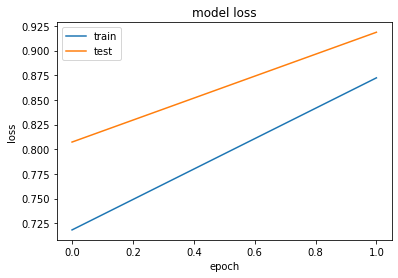

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
movie_df = pd.read_csv("/content/movies.csv")

In [ ]:
# Let us get a user and see the top recommendations.
user_id = training_full.userId.sample(1).iloc[0]
movies_watched_by_user = training_full[training_full.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

1525/1525 [==============================] - 4s 2ms/step
Showing recommendations for user: 113403
Movies with high ratings from user
--------------------------------
Stardust (2007) : Adventure,Comedy,Fantasy,Romance
Avatar (2009) : Action,Adventure,Sci-Fi,IMAX
Upside Down (2012) : Drama,Romance,Sci-Fi
Seventh Son (2014) : Adventure,Children,Fantasy
Star Wars: Episode VII - The Force Awakens (2015) : Action,Adventure,Fantasy,Sci-Fi,IMAX
--------------------------------
Top 10 movie recommendations
--------------------------------
Romancing the Stone (1984) : Action,Adventure,Comedy,Romance
Rocky II (1979) : Action,Drama
Clue (1985) : Comedy,Crime,Mystery,Thriller
Karate Kid, The (1984) : Drama
Christmas Vacation (National Lampoon's Christmas Vacation) (1989) : Comedy
Thin Red Line, The (1998) : Action,Drama,War
Stepmom (1998) : Drama
Civil Action, A (1998) : Drama
Tea with Mussolini (1999) : Comedy,Drama,War
Wilde (1997) : Drama
